In [162]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [443]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import glob
import requests
from bs4 import BeautifulSoup

# ensure that all columns are shown and that colum content is not cut
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 500) # ensure that all rows are shown

# Formulas

In [444]:
def quarters(month):
    if month <= 3:
        return 'Q1'
    if month <= 6:
        return 'Q2'
    if month <= 9:
        return 'Q3'
    return 'Q4'

# Data Analysis - Corporate Financial Data

## Loading Data

In [460]:
## Load Data
agg_path = '../raw_data/SEC_data/Simple/Aggregated/'
df_path = '../raw_data/secfsdstools/df/'
datasets = '../raw_data/datasets'

balance_sheet = pd.read_csv(df_path+'balance_sheet.csv', index_col=0)
income_statement = pd.read_csv(df_path+'income_statement.csv', index_col=0)
cash_flow_statement = pd.read_csv(df_path+'cash_flow_narrow.csv', index_col=0)
cash_flow_statement_ext = pd.read_csv(df_path+'cash_flow_extended.csv', index_col=0)

sub = pd.read_csv(agg_path+'sub_all.csv', index_col=0)
sub = sub[['adsh', 'sic', 'stprba',
           'afs', 'nciks']]

In [461]:
#Clean up financial statements

balance_sheet.drop(['index', 'coreg', 'report', 'form', 'fye', 'qtrs'], axis=1, inplace=True)
income_statement.drop(['index', 'coreg', 'report', 'form', 'fye', 'qtrs'], axis=1, inplace=True)
cash_flow_statement.drop(['index', 'coreg', 'report', 'form', 'fye', 'qtrs'], axis=1, inplace=True)

balance_sheet.drop_duplicates(inplace=True)
income_statement.drop_duplicates(inplace=True)
cash_flow_statement.drop_duplicates(inplace=True)

balance_sheet['date'] = pd.to_datetime(balance_sheet['date'])
income_statement['date'] = pd.to_datetime(income_statement['date'])
cash_flow_statement['date'] = pd.to_datetime(cash_flow_statement['date'])

# Remove 2009 and earlier

balance_sheet = balance_sheet[(balance_sheet.date.dt.year>=2010)&(balance_sheet.date.dt.year<2025)]
income_statement = income_statement[(income_statement.date.dt.year>=2010)&(income_statement.date.dt.year<2025)]
cash_flow_statement = cash_flow_statement[(cash_flow_statement.date.dt.year>=2010)&(cash_flow_statement.date.dt.year<2025)]


In [462]:
print(f'{balance_sheet.shape = }, {income_statement.shape = }, {cash_flow_statement.shape = }')

balance_sheet.shape = (238094, 24), income_statement.shape = (269353, 21), cash_flow_statement.shape = (285369, 20)


## Merging & Cleaning Data

Revenues
CostOfRevenue
GrossProfit
OperatingExpenses
OperatingIncomeLoss
IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit
AllIncomeTaxExpenseBenefit
IncomeLossFromContinuingOperations
IncomeLossFromDiscontinuedOperationsNetOfTax
ProfitLoss
NetIncomeLossAttributableToNoncontrollingInterest
NetIncomeLoss


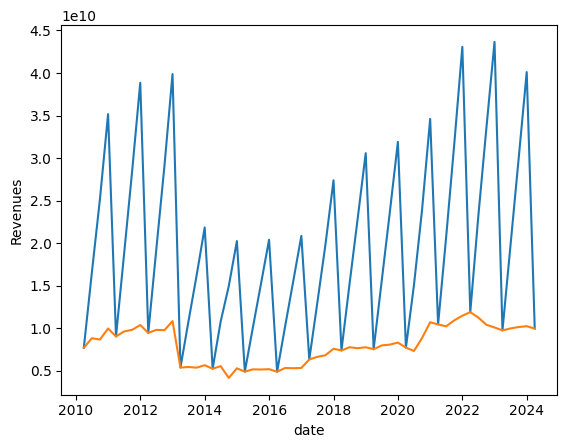

In [463]:
# Difference quarterly data for income statements

income_statement_adj = income_statement.sort_values(['cik', 'date']).reset_index(drop=True)
for col in income_statement_adj.columns[8:-1]:
    print(col)
    income_statement_adj[col] = (income_statement_adj.groupby(['cik','fy'])[col].diff().fillna(income_statement_adj[col])    )

# Visualize 
test = income_statement[income_statement.cik==1800]
test_adj = income_statement_adj[income_statement_adj.cik==1800]

sns.lineplot(x=test.date, y=test.Revenues);
sns.lineplot(x=test_adj.date, y=test_adj.Revenues);

In [464]:
df_financials = balance_sheet.merge(income_statement_adj, how='inner', on=['adsh', 'cik', 'name', 'fy', 'fp', 'date', 'filed', 'ddate'], 
                                   suffixes=('_bs', '_is'))
df_financials = df_financials.merge(cash_flow_statement, how='inner', on=['adsh', 'cik', 'name', 'fy', 'fp', 'date', 'filed', 'ddate'], 
                                   suffixes=('', '_cf'))
df_financials = df_financials.merge(sub, how='left', on='adsh')
df_financials.shape
#230863 observations


(230863, 53)

In [465]:
# Create 2-digit SIC Code

df_financials['sic_2d'] = df_financials.sic.apply(lambda x: str(x)[:2])
df_financials.sic_2d.nunique() #69

69

In [466]:
df_financials['quarter'] = df_financials.apply(lambda x: str(x.date.year)+'-'+quarters(x.date.month), axis=1)
df_financials['year'] = df_financials.date.dt.year
df_financials['n_year'] = df_financials.groupby(['cik', 'year'])['year'].transform('count')
df_financials = df_financials[df_financials.n_year==4]
df_financials.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192272 entries, 2 to 227342
Data columns (total 57 columns):
 #   Column                                                           Non-Null Count   Dtype         
---  ------                                                           --------------   -----         
 0   adsh                                                             192272 non-null  object        
 1   cik                                                              192272 non-null  int64         
 2   name                                                             192272 non-null  object        
 3   fy                                                               192272 non-null  float64       
 4   fp                                                               192272 non-null  object        
 5   date                                                             192272 non-null  datetime64[ns]
 6   filed                                                            192272 n

In [467]:

drop_cols = ['adsh', 'name', 'fy', 'fp', 'filed', 'ddate', 'n_cik_bs', 'n_cik_is', 'n_cik', 'sic', 'n_year']

df_financials.drop(columns=drop_cols, inplace=True)


df_financials = df_financials.sort_values(['cik', 'date']).drop_duplicates().reset_index(drop=True)
df_financials.to_csv(datasets+'/df_financials.csv')

df_financials.info()

#230860 observations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192272 entries, 0 to 192271
Data columns (total 46 columns):
 #   Column                                                           Non-Null Count   Dtype         
---  ------                                                           --------------   -----         
 0   cik                                                              192272 non-null  int64         
 1   date                                                             192272 non-null  datetime64[ns]
 2   Assets                                                           192272 non-null  float64       
 3   AssetsCurrent                                                    192272 non-null  float64       
 4   Cash                                                             192272 non-null  float64       
 5   AssetsNoncurrent                                                 192272 non-null  float64       
 6   Liabilities                                                      192

In [468]:
df_financials.cik.nunique()

6239

In [469]:
df_financials.describe().T

,count,mean,min,25%,50%,75%,max,std
cik,192272.0,1033746.47206,1750.0,818033.0,1083231.5,1421461.0,1812364.0,485547.765537
date,192272,2017-11-05 04:24:35.559623936,2010-01-31 00:00:00,2014-12-31 00:00:00,2017-09-30 00:00:00,2020-09-30 00:00:00,2023-12-31 00:00:00,NaN
Assets,192272.0,12596853637.30641,-47832271000.0,61266750.0,694384500.0,3638967500.0,4329380000000.0,109750747869.126389
AssetsCurrent,192272.0,9558765244.374557,-47832271000.0,32644750.0,322236500.0,1632815000.0,4329380000000.0,108544711006.170532
Cash,192272.0,546804319.666163,-27475000.0,6566160.5,48673000.0,219390000.0,301006000000.0,4101145698.283493
AssetsNoncurrent,192272.0,2969975858.98702,-482203000.0,92707.75,40953527.0,891306750.0,501912000000.0,14116029002.776033
Liabilities,192272.0,10183521333.90139,-43421954000.0,20594000.0,361355000.0,2366994000.0,4255655000000.0,102216972783.650543
LiabilitiesCurrent,192272.0,7896447601.713912,-43421954000.0,12377968.25,141300000.0,1014600000.0,4255655000000.0,97159263858.715805
LiabilitiesNoncurrent,192272.0,2259237949.316916,-10887600000.0,168378.5,28472437.5,694878000.0,511653000000.0,11763138228.154516
Equity,192272.0,2373142678.872301,-18075000000.0,18577750.0,205126983.5,1110989250.0,351954000000.0,11526874749.736393


## Save Sample & CIK

In [470]:
# Save sample of company data

abbot = df_financials[df_financials.cik==1800]
abbot.to_csv('../raw_data/secfsdstools/df/abbot_sample.csv')
abbot.head()

,cik,date,Assets,AssetsCurrent,Cash,AssetsNoncurrent,Liabilities,LiabilitiesCurrent,LiabilitiesNoncurrent,Equity,HolderEquity,RetainedEarnings,AdditionalPaidInCapital,TreasuryStockValue,TemporaryEquity,RedeemableEquity,LiabilitiesAndEquity,Revenues,CostOfRevenue,GrossProfit,OperatingExpenses,OperatingIncomeLoss,IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit,AllIncomeTaxExpenseBenefit,IncomeLossFromContinuingOperations,IncomeLossFromDiscontinuedOperationsNetOfTax,ProfitLoss,NetIncomeLossAttributableToNoncontrollingInterest,NetIncomeLoss,NetCashProvidedByUsedInOperatingActivitiesContinuingOperations,NetCashProvidedByUsedInFinancingActivitiesContinuingOperations,NetCashProvidedByUsedInInvestingActivitiesContinuingOperations,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInFinancingActivities,NetCashProvidedByUsedInInvestingActivities,CashProvidedByUsedInOperatingActivitiesDiscontinuedOperations,CashProvidedByUsedInInvestingActivitiesDiscontinuedOperations,CashProvidedByUsedInFinancingActivitiesDiscontinuedOperations,EffectOfExchangeRateFinal,CashPeriodIncreaseDecreaseIncludingExRateEffectFinal,stprba,afs,nciks,sic_2d,quarter,year
52,1800,2010-03-31,5.335862e+10,1.769068e+10,1.566820e+09,3.566794e+10,3.234628e+10,1.518348e+10,1.716280e+10,2.101234e+10,2.101234e+10,1.736786e+10,0.0,-3.945682e+09,0.0,0.0,5.335862e+10,7.698354e+09,3.335104e+09,4.363250e+09,2.892767e+09,1.470483e+09,1.322207e+09,319192000.0,1.003015e+09,0.0,1.003015e+09,0.0,1.003015e+09,1.522752e+09,-5.201990e+08,-7.658760e+09,1.522752e+09,-5.201990e+08,-7.658760e+09,0.0,0.0,0.0,-586312000.0,-7.242519e+09,IL,1-LAF,1.0,28,2010-Q1,2010
53,1800,2010-06-30,5.338140e+10,1.991531e+10,4.321702e+09,3.346610e+10,3.338677e+10,1.468926e+10,1.869751e+10,1.999463e+10,1.999463e+10,1.797846e+10,0.0,-3.942188e+09,0.0,0.0,5.338140e+10,8.826014e+09,3.543932e+09,5.282082e+09,3.676116e+09,1.605966e+09,1.558687e+09,267037000.0,1.291650e+09,0.0,1.291650e+09,0.0,1.291650e+09,3.871049e+09,-3.073210e+08,-7.354928e+09,3.871049e+09,-3.073210e+08,-7.354928e+09,0.0,0.0,0.0,-696437000.0,-4.487637e+09,IL,1-LAF,1.0,28,2010-Q2,2010
54,1800,2010-09-30,5.737362e+10,1.944742e+10,3.818145e+09,3.792620e+10,3.589090e+10,1.558387e+10,2.030702e+10,2.148272e+10,2.148272e+10,1.818113e+10,0.0,-3.918310e+09,0.0,0.0,5.737362e+10,8.674505e+09,3.741116e+09,4.933389e+09,3.752204e+09,1.181185e+09,1.064110e+09,173450000.0,8.906600e+08,0.0,8.906600e+08,0.0,8.906600e+08,6.419462e+09,-9.944270e+08,-9.747926e+09,6.419462e+09,-9.944270e+08,-9.747926e+09,0.0,0.0,0.0,-668303000.0,-4.991194e+09,IL,1-LAF,1.0,28,2010-Q3,2010
55,1800,2010-12-31,5.946227e+10,2.231753e+10,3.648371e+09,3.714474e+10,3.698580e+10,1.726243e+10,1.972337e+10,2.247646e+10,2.247646e+10,1.892710e+10,0.0,-3.916823e+09,0.0,0.0,5.946227e+10,9.967848e+09,4.045040e+09,5.922808e+09,4.092861e+09,1.829947e+09,1.767830e+09,326983000.0,1.440847e+09,0.0,1.440847e+09,0.0,1.440847e+09,8.735981e+09,-1.087741e+09,-1.218832e+10,8.735981e+09,-1.087741e+09,-1.218832e+10,0.0,0.0,0.0,-620893000.0,-5.160968e+09,IL,1-LAF,1.0,28,2010-Q4,2010
56,1800,2011-03-31,6.165136e+10,2.364713e+10,2.740156e+09,3.800423e+10,3.693103e+10,1.722510e+10,1.970593e+10,2.472033e+10,2.472033e+10,1.932375e+10,0.0,-3.718827e+09,0.0,0.0,6.165136e+10,9.040850e+09,3.858983e+09,5.181867e+09,3.880718e+09,1.301149e+09,1.068786e+09,204968000.0,8.638180e+08,0.0,8.638180e+08,0.0,8.638180e+08,2.011146e+09,-6.843340e+08,-2.301230e+09,2.011146e+09,-6.843340e+08,-2.301230e+09,0.0,0.0,0.0,66203000.0,-9.082150e+08,IL,1-LAF,1.0,28,2011-Q1,2011


In [471]:
# Save list of unique CIK identifiers

final_cik_list = df_financials[['cik']].drop_duplicates()
final_cik_list.to_csv(df_path+'final_cik_list.csv')

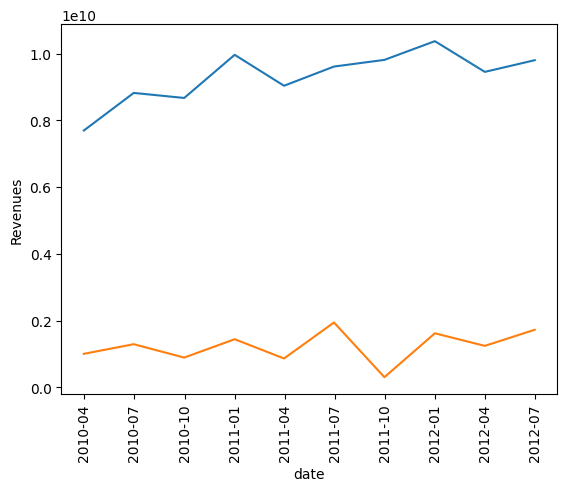

In [472]:
abbot = df_financials[df_financials.cik==1800].iloc[:10]
sns.lineplot(x='date', y='Revenues', data=abbot);
sns.lineplot(x='date', y='NetIncomeLoss', data=abbot);
plt.xticks(rotation=90);

# Fred Data

In [473]:
fred = pd.read_csv('../raw_data/Datasets/processed_FRED_data_2.csv')
fred['date'] = pd.to_datetime(fred.Date) + pd.tseries.offsets.MonthEnd(0)

fred.drop(['Date'], axis=1, inplace=True)
fred = fred[fred.date.dt.year>=2010]

#fred.groupby(pd.PeriodIndex(fred.Date, freq='Q')).mean()
#fred.set_index('Date', inplace=True)
fred.head()

,GDP,interest_rate,unemployment_rate,median_cpi,date
120,1.042123,0.11,9.7,0.680111,2010-01-31
121,1.033352,0.13,9.7,-0.106628,2010-02-28
122,4.165865,0.16,9.7,-0.286064,2010-03-31
123,4.720938,0.20,9.9,0.452616,2010-04-30
124,4.016599,0.20,9.7,0.275748,2010-05-31


In [474]:
# Merge monthly data onto the quarter - shows only the condition of the economy during the reporting month 
# (i.e. the last month of the reporting quarter)

df_fin_fred = df_financials.merge(fred, how='left', on='date')
df_fin_fred.reset_index(drop=True, inplace=True)
df_fin_fred.to_csv(datasets+'/df_financials_fred.csv')

df_fin_fred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192272 entries, 0 to 192271
Data columns (total 50 columns):
 #   Column                                                           Non-Null Count   Dtype         
---  ------                                                           --------------   -----         
 0   cik                                                              192272 non-null  int64         
 1   date                                                             192272 non-null  datetime64[ns]
 2   Assets                                                           192272 non-null  float64       
 3   AssetsCurrent                                                    192272 non-null  float64       
 4   Cash                                                             192272 non-null  float64       
 5   AssetsNoncurrent                                                 192272 non-null  float64       
 6   Liabilities                                                      192

In [476]:
df_fin_fred.cik.nunique()

6239

# Market Cap and Stocks

In [523]:
market_cap = pd.read_csv(datasets+'/marketcap_shares_outstanding.csv')
stocks_yahoo = pd.read_csv(datasets+'/processed_yahoo_data.csv')
stocks_kaggle = pd.read_csv(datasets+'/processed_data.csv')
tickers = pd.read_csv(datasets+'/tickers_with_cik_list_with_sec_ciks.csv')

## Market Cap

In [524]:
market_cap.head()

,Ticker,Date,Monthly Avg Market Cap,Monthly Market Cap (End of Month),Shares Outstanding
0,FLIC,2010-01-31 00:00:00-05:00,1.474772e+08,1.439013e+08,22531300
1,FLIC,2010-02-28 00:00:00-05:00,1.416695e+08,1.492464e+08,22531300
2,FLIC,2010-03-31 00:00:00-04:00,1.500160e+08,1.442612e+08,22531300
3,FLIC,2010-04-30 00:00:00-04:00,1.477159e+08,1.540781e+08,22531300
4,FLIC,2010-05-31 00:00:00-04:00,1.546587e+08,1.517435e+08,22531300


0.0


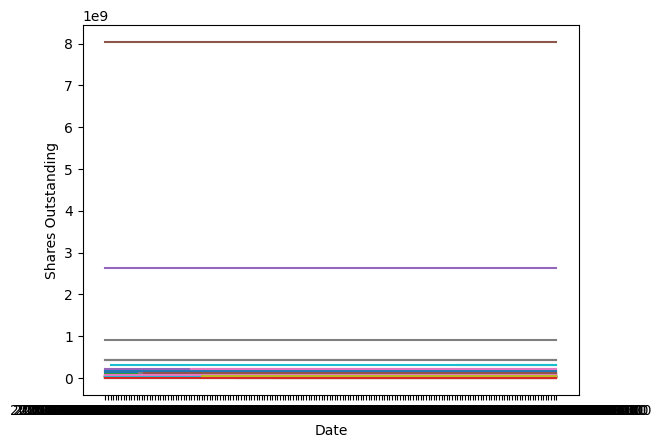

In [525]:
# Sense check on Shares

print(market_cap.groupby('Ticker')['Shares Outstanding'].std().max())

for t in market_cap.Ticker.unique()[200:250]:
    sns.lineplot(x = market_cap[market_cap.Ticker==t].Date, y = market_cap[market_cap.Ticker==t]['Shares Outstanding'])
    


In [526]:
market_cap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528075 entries, 0 to 528074
Data columns (total 5 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Ticker                             528075 non-null  object 
 1   Date                               528075 non-null  object 
 2   Monthly Avg Market Cap             528075 non-null  float64
 3   Monthly Market Cap (End of Month)  528075 non-null  float64
 4   Shares Outstanding                 528075 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 20.1+ MB


In [527]:
#Clean Market Cap

market_cap['date'] = market_cap.Date.apply(lambda x: pd.to_datetime(x[:7], format='%Y-%m') + pd.tseries.offsets.MonthEnd(0))
market_cap['quarter'] = market_cap['date'].apply(lambda x: str(x.year)+'-'+quarters(x.month))
market_cap.drop(['Shares Outstanding', 'Date', 'Monthly Market Cap (End of Month)'], axis=1, inplace=True)
market_cap.head()


,Ticker,Monthly Avg Market Cap,date,quarter
0,FLIC,1.474772e+08,2010-01-31,2010-Q1
1,FLIC,1.416695e+08,2010-02-28,2010-Q1
2,FLIC,1.500160e+08,2010-03-31,2010-Q1
3,FLIC,1.477159e+08,2010-04-30,2010-Q2
4,FLIC,1.546587e+08,2010-05-31,2010-Q2


In [528]:
market_cap_qtr = market_cap.groupby(['Ticker', 'quarter'], as_index=False).agg({'Monthly Avg Market Cap': 'mean', 
                                                                           'date': 'last'})


market_cap_qtr.drop('quarter', axis=1, inplace=True)

market_cap_qtr.head()

,Ticker,Monthly Avg Market Cap,date
0,A,5.867042e+09,2010-03-31
1,A,6.236717e+09,2010-06-30
2,A,5.432837e+09,2010-09-30
3,A,6.832947e+09,2010-12-31
4,A,8.087156e+09,2011-03-31


In [529]:
tickers = tickers[tickers.Active==True]
tickers.drop('Active', inplace=True, axis=1)
tickers.drop_duplicates(inplace=True)

tickers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2781 entries, 2 to 9110
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cik     2781 non-null   int64 
 1   Ticker  2781 non-null   object
dtypes: int64(1), object(1)
memory usage: 65.2+ KB


## Dealing with duplicate ticker-ciks

In [533]:
idx = stocks_marketcap.groupby('cik')['Ticker'].nunique()[stocks_marketcap.groupby('cik')['Ticker'].nunique()>1].index

In [534]:
ticks = stocks_marketcap[stocks_marketcap.cik.isin(idx)].Ticker.unique()

In [535]:
ciks = tickers[tickers.Ticker.isin(ticks)].cik.unique()

In [536]:
dups = df_financials[df_financials.cik.isin(ciks)].groupby('cik', as_index=False).first().loc[:, ['cik']].merge(dups, on='cik', how='inner')


In [537]:
ids = []
for row in dups.itertuples():
    ids.append(tickers[(tickers.Ticker==row.Ticker)&(tickers.cik==row.cik)].index[0])
tickers.drop(ids, inplace=True)

In [538]:
tickers.shape

(2766, 2)

In [539]:
mc_ticker = tickers.merge(market_cap_qtr, on='Ticker', how='inner')
mc_ticker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65506 entries, 0 to 65505
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cik                     65506 non-null  int64         
 1   Ticker                  65506 non-null  object        
 2   Monthly Avg Market Cap  65506 non-null  float64       
 3   date                    65506 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.0+ MB


In [540]:
mc_ticker.head()

,cik,Ticker,Monthly Avg Market Cap,date
0,34782,SRCE,2.901491e+08,2010-03-31
1,34782,SRCE,3.413191e+08,2010-06-30
2,34782,SRCE,3.232363e+08,2010-09-30
3,34782,SRCE,3.590849e+08,2010-12-31
4,34782,SRCE,3.647185e+08,2011-03-31


In [541]:
mc_ticker.cik.nunique()

1232

## Stocks

In [542]:
stocks_yahoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220370 entries, 0 to 220369
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Ticker                220370 non-null  object 
 1   Month                 220370 non-null  object 
 2   Monthly_Avg_Close     220370 non-null  float64
 3   Monthly_Volume_Total  220370 non-null  float64
 4   Monthly_Volume_Avg    220370 non-null  float64
 5   Monthly_Volatility    217422 non-null  float64
dtypes: float64(4), object(2)
memory usage: 10.1+ MB


In [543]:
stocks_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467055 entries, 0 to 467054
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Ticker                466960 non-null  object 
 1   Month                 467055 non-null  object 
 2   Monthly_Avg_Close     467055 non-null  float64
 3   Monthly_Volume_Total  467055 non-null  int64  
 4   Monthly_Volume_Avg    467055 non-null  float64
 5   Monthly_Volatility    466200 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 21.4+ MB


In [544]:
stocks = pd.concat((stocks_kaggle, stocks_yahoo), axis=0).reset_index(drop=True)
stocks.shape

(687425, 6)

In [545]:
stocks['date'] = pd.to_datetime(stocks.Month, format='%Y-%m') + pd.tseries.offsets.MonthEnd(0)
stocks['quarter'] = stocks.apply(lambda x: str(x.date.year)+'-'+quarters(x.date.month), axis=1)
stocks.drop(columns=['Month', 'Monthly_Volume_Avg'], inplace=True)
stocks.head()

,Ticker,Monthly_Avg_Close,Monthly_Volume_Total,Monthly_Volatility,date,quarter
0,iba,20.339737,87729.0,0.165217,2010-01-31,2010-Q1
1,iba,18.075000,121023.0,0.251822,2010-02-28,2010-Q1
2,iba,18.729565,371489.0,0.207545,2010-03-31,2010-Q1
3,iba,18.811762,177267.0,0.204060,2010-04-30,2010-Q2
4,iba,18.390950,266529.0,0.231837,2010-05-31,2010-Q2


In [546]:
stocks_qtr = stocks.groupby(['Ticker', 'quarter'], as_index=False).agg({'Monthly_Avg_Close': 'mean', 
                                                                           'Monthly_Volume_Total': 'mean', 
                                                                           'Monthly_Volatility': 'mean', 
                                                                           'date': 'last'})
stocks_qtr.drop('quarter', axis=1, inplace=True)

stocks_qtr.head()

,Ticker,Monthly_Avg_Close,Monthly_Volume_Total,Monthly_Volatility,date
0,A,50.372602,4.172707e+07,0.113482,2017-03-31
1,A,56.799051,4.201503e+07,0.096083,2017-06-30
2,A,62.337391,3.462220e+07,0.091808,2017-09-30
3,A,67.458907,3.649747e+07,0.090278,2017-12-31
4,A,70.081621,5.006897e+07,0.150821,2018-03-31


In [547]:
stocks_qtr.Ticker.nunique()

10192

## Merge stocks & market cap


In [548]:
stocks_marketcap = mc_ticker.merge(stocks_qtr, on=['Ticker', 'date'], how='inner')
stocks_marketcap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36481 entries, 0 to 36480
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cik                     36481 non-null  int64         
 1   Ticker                  36481 non-null  object        
 2   Monthly Avg Market Cap  36481 non-null  float64       
 3   date                    36481 non-null  datetime64[ns]
 4   Monthly_Avg_Close       36481 non-null  float64       
 5   Monthly_Volume_Total    36481 non-null  float64       
 6   Monthly_Volatility      36476 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.9+ MB


In [549]:
stocks_marketcap.cik.nunique()

1232

# Merge all sets

In [550]:
df_fin_fred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192272 entries, 0 to 192271
Data columns (total 50 columns):
 #   Column                                                           Non-Null Count   Dtype         
---  ------                                                           --------------   -----         
 0   cik                                                              192272 non-null  int64         
 1   date                                                             192272 non-null  datetime64[ns]
 2   Assets                                                           192272 non-null  float64       
 3   AssetsCurrent                                                    192272 non-null  float64       
 4   Cash                                                             192272 non-null  float64       
 5   AssetsNoncurrent                                                 192272 non-null  float64       
 6   Liabilities                                                      192

In [551]:
stocks_marketcap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36481 entries, 0 to 36480
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cik                     36481 non-null  int64         
 1   Ticker                  36481 non-null  object        
 2   Monthly Avg Market Cap  36481 non-null  float64       
 3   date                    36481 non-null  datetime64[ns]
 4   Monthly_Avg_Close       36481 non-null  float64       
 5   Monthly_Volume_Total    36481 non-null  float64       
 6   Monthly_Volatility      36476 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.9+ MB


In [552]:
merged_df = df_fin_fred.merge(stocks_marketcap, on=['cik', 'date'], how='inner')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24266 entries, 0 to 24265
Data columns (total 55 columns):
 #   Column                                                           Non-Null Count  Dtype         
---  ------                                                           --------------  -----         
 0   cik                                                              24266 non-null  int64         
 1   date                                                             24266 non-null  datetime64[ns]
 2   Assets                                                           24266 non-null  float64       
 3   AssetsCurrent                                                    24266 non-null  float64       
 4   Cash                                                             24266 non-null  float64       
 5   AssetsNoncurrent                                                 24266 non-null  float64       
 6   Liabilities                                                      24266 non-nul

In [553]:
merged_df.cik.nunique()

972

In [554]:
merged_df.to_csv(datasets+'/merged_data.csv')